In [1]:
import math, re, os, time
import tensorflow as tf, tensorflow.keras.backend as K
import tensorflow_probability as tfp
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, classification_report
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.1.0


In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus') # you can list the bucket with "!gsutil ls $GCS_DS_PATH"
CUSTOM_DS_PATH = KaggleDatasets().get_gcs_path('oxford-102-for-tpu-competition')

# Configuration

In [4]:
IMAGE_SIZE = [224, 224] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 30
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition
CUSTOM_DS_FILENAMES = tf.io.gfile.glob(f'{CUSTOM_DS_PATH}/tfrecords-jpeg-{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}/*.tfrec')

TRAINING_FILENAMES += CUSTOM_DS_FILENAMES

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# Dataset functions

In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # Diregarding data order. Order does not matter since we will be shuffling the data anyway
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # use data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO) # returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeld = False
    return dataset

def get_training_dataset(augment=True):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    
    if augment: 
        dataset = dataset.map(lambda img, label: (img, augmix(img), augmix(img), label), num_parallel_calls=AUTO)
        
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False, repeated=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=repeated) # slighly faster with fixed tensor sizes
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def int_div_round_up(a, b):
    return (a + b - 1) // b

# Data visualization

In [6]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None, figsize  = 13.0):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE =  figsize
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Data augmentation

## Helpers

In [7]:
def int_parameter(level, maxval):
    return tf.cast(level * maxval / 10, tf.int32)

def float_parameter(level, maxval):
    return tf.cast((level) * maxval / 10., tf.float32)

def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)
    
def affine_transform(image, transform_matrix):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    x = tf.repeat(tf.range(DIM//2,-DIM//2,-1), DIM)
    y = tf.tile(tf.range(-DIM//2,DIM//2), [DIM])
    z = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack([x, y, z])
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(transform_matrix, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d = tf.gather_nd(image, tf.transpose(idx3))
    return tf.reshape(d,[DIM,DIM,3])

def blend(image1, image2, factor):
    if factor == 0.0:
        return tf.convert_to_tensor(image1)
    if factor == 1.0:
        return tf.convert_to_tensor(image2)

    image1 = tf.cast(image1, tf.float32)
    image2 = tf.cast(image2, tf.float32)

    difference = image2 - image1
    scaled = factor * difference

    # Do addition in float.
    temp = tf.cast(image1, tf.float32) + scaled

    # Interpolate
    if factor > 0.0 and factor < 1.0:
        # Interpolation means we always stay within 0 and 255.
        return tf.cast(temp, tf.uint8)

    # Extrapolate:
    #
    # We need to clip and then cast.
    return tf.cast(tf.clip_by_value(temp, 0.0, 255.0), tf.uint8)

## Transformations 

In [8]:
def rotate(image, level):
    degrees = float_parameter(sample_level(level), 30)
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    degrees = tf.cond(rand_var > 0.5, lambda: degrees, lambda: -degrees)

    angle = math.pi*degrees/180 # convert degrees to radians
    angle = tf.cast(angle, tf.float32)
    # define rotation matrix
    c1 = tf.math.cos(angle)
    s1 = tf.math.sin(angle)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one], axis=0), [3,3])

    transformed = affine_transform(image, rotation_matrix)
    return transformed

def translate_x(image, level):
    lvl = int_parameter(sample_level(level), IMAGE_SIZE[0] / 3)
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    lvl = tf.cond(rand_var > 0.5, lambda: lvl, lambda: -lvl)

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    lvl = tf.cast(lvl, tf.float32)
    translate_x_matrix = tf.reshape(tf.concat([one,zero,zero, zero,one,lvl, zero,zero,one], axis=0), [3,3])

    transformed = affine_transform(image, translate_x_matrix)
    return transformed

def translate_y(image, level):
    lvl = int_parameter(sample_level(level), IMAGE_SIZE[0] / 3)
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    lvl = tf.cond(rand_var > 0.5, lambda: lvl, lambda: -lvl)

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    lvl = tf.cast(lvl, tf.float32)
    translate_y_matrix = tf.reshape(tf.concat([one,zero,lvl, zero,one,zero, zero,zero,one], axis=0), [3,3])

    transformed = affine_transform(image, translate_y_matrix)
    return transformed

def shear_x(image, level):
    lvl = float_parameter(sample_level(level), 0.3)
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    lvl = tf.cond(rand_var > 0.5, lambda: lvl, lambda: -lvl)

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    s2 = tf.math.sin(lvl)
    shear_x_matrix = tf.reshape(tf.concat([one,s2,zero, zero,one,zero, zero,zero,one],axis=0), [3,3])   

    transformed = affine_transform(image, shear_x_matrix)
    return transformed

def shear_y(image, level):
    lvl = float_parameter(sample_level(level), 0.3)
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    lvl = tf.cond(rand_var > 0.5, lambda: lvl, lambda: -lvl)

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    c2 = tf.math.cos(lvl)
    shear_y_matrix = tf.reshape(tf.concat([one,zero,zero, zero,c2,zero, zero,zero,one],axis=0), [3,3])   
    
    transformed = affine_transform(image, shear_y_matrix)
    return transformed

def solarize(image, level):
    # For each pixel in the image, select the pixel
    # if the value is less than the threshold.
    # Otherwise, subtract 255 from the pixel.
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 1 - image)

def solarize_add(image, level):
    # For each pixel in the image less than threshold
    # we add 'addition' amount to it and then clip the
    # pixel value to be between 0 and 255. The value
    # of 'addition' is between -128 and 128.
    threshold = float_parameter(sample_level(level), 1)
    addition = float_parameter(sample_level(level), 0.5)
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    addition = tf.cond(rand_var > 0.5, lambda: addition, lambda: -addition)

    added_image = tf.cast(image, tf.float32) + addition
    added_image = tf.cast(tf.clip_by_value(added_image, 0, 1), tf.float32)
    return tf.where(image < threshold, added_image, image)

def posterize(image, level):
    lvl = int_parameter(sample_level(level), 8)
    shift = 8 - lvl
    shift = tf.cast(shift, tf.uint8)
    image = tf.cast(tf.math.scalar_mul(255, image), tf.uint8)
    image = tf.bitwise.left_shift(tf.bitwise.right_shift(image, shift), shift)
    return tf.cast(tf.clip_by_value(tf.math.divide(image, 255), 0, 1), tf.float32)

def autocontrast(image, _):
    image = tf.cast(tf.math.scalar_mul(255, image), tf.uint8)

    def scale_channel(image):
        # A possibly cheaper version can be done using cumsum/unique_with_counts
        # over the histogram values, rather than iterating over the entire image.
        # to compute mins and maxes.
        lo = tf.cast(tf.reduce_min(image), tf.float32)
        hi = tf.cast(tf.reduce_max(image), tf.float32)

        # Scale the image, making the lowest value 0 and the highest value 255.
        def scale_values(im):
            scale = 255.0 / (hi - lo)
            offset = -lo * scale
            im = tf.cast(im, tf.float32) * scale + offset
            im = tf.clip_by_value(im, 0.0, 255.0)
            return tf.cast(im, tf.uint8)

        result = tf.cond(hi > lo, lambda: scale_values(image), lambda: image)
        return result

    # Assumes RGB for now.  Scales each channel independently
    # and then stacks the result.
    s1 = scale_channel(image[:, :, 0])
    s2 = scale_channel(image[:, :, 1])
    s3 = scale_channel(image[:, :, 2])
    image = tf.stack([s1, s2, s3], 2)
    return tf.cast(tf.clip_by_value(tf.math.divide(image, 255), 0, 1), tf.float32)

def equalize(image, _):
    image = tf.cast(tf.math.scalar_mul(255, image), tf.uint8)

    def scale_channel(im, c):
        im = tf.cast(im[:, :, c], tf.int32)
        # Compute the histogram of the image channel.
        histo = tf.histogram_fixed_width(im, [0, 255], nbins=256)
        # For the purposes of computing the step, filter out the nonzeros.
        nonzero = tf.where(tf.not_equal(histo, 0))
        nonzero_histo = tf.reshape(tf.gather(histo, nonzero), [-1])
        step = (tf.reduce_sum(nonzero_histo) - nonzero_histo[-1]) // 255

        def build_lut(histo, step):
            # Compute the cumulative sum, shifting by step // 2
            # and then normalization by step.
            lut = (tf.cumsum(histo) + (step // 2)) // step
            # Shift lut, prepending with 0.
            lut = tf.concat([[0], lut[:-1]], 0)
            # Clip the counts to be in range.  This is done
            # in the C code for image.point.
            return tf.clip_by_value(lut, 0, 255)

        # If step is zero, return the original image.  Otherwise, build
        # lut from the full histogram and step and then index from it.
        result = tf.cond(tf.equal(step, 0),
                        lambda: im,
                        lambda: tf.gather(build_lut(histo, step), im))

        return tf.cast(result, tf.uint8)

    # Assumes RGB for now.  Scales each channel independently
    # and then stacks the result.
    s1 = scale_channel(image, 0)
    s2 = scale_channel(image, 1)
    s3 = scale_channel(image, 2)
    image = tf.stack([s1, s2, s3], 2)

    return tf.cast(tf.clip_by_value(tf.math.divide(image, 255), 0, 1), tf.float32)

def color(image, level):
    factor = float_parameter(sample_level(level), 1.8) + 0.1
    image = tf.cast(tf.math.scalar_mul(255, image), tf.uint8)
    degenerate = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))
    blended = blend(degenerate, image, factor)
    return tf.cast(tf.clip_by_value(tf.math.divide(blended, 255), 0, 1), tf.float32)

def brightness(image, level):
    delta = float_parameter(sample_level(level), 0.5) + 0.1
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    delta = tf.cond(rand_var > 0.5, lambda: delta, lambda: -delta) 
    return tf.image.adjust_brightness(image, delta=delta)

def contrast(image, level):
    factor = float_parameter(sample_level(level), 1.8) + 0.1
    factor = tf.reshape(factor, [])
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    factor = tf.cond(rand_var > 0.5, lambda: factor, lambda: 1.9 - factor  )

    return tf.image.adjust_contrast(image, factor)




## AugMix 

In [9]:
means = {'R': 0.44892993872313053, 'G': 0.4148519066242368, 'B': 0.301880284715257}
stds = {'R': 0.24393544875614917, 'G': 0.2108791383467354, 'B': 0.220427056859487}

def substract_means(image):
    image = image - np.array([means['R'], means['G'], means['B']])
    return image

def normalize(image):
    image = substract_means(image)
    image = image / np.array([stds['R'], stds['G'], stds['B']])
    return tf.clip_by_value(image, 0, 1)

def apply_op(image, level, which): 
    # cannot find another way to randomply select a function in tensorflow
    augmented = image
    augmented = tf.cond(which == tf.constant([0], dtype=tf.int32), lambda: rotate(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([1], dtype=tf.int32), lambda: translate_x(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([2], dtype=tf.int32), lambda: translate_y(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([3], dtype=tf.int32), lambda: shear_x(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([4], dtype=tf.int32), lambda: shear_y(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([5], dtype=tf.int32), lambda: solarize_add(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([6], dtype=tf.int32), lambda: solarize(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([7], dtype=tf.int32), lambda: posterize(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([8], dtype=tf.int32), lambda: autocontrast(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([9], dtype=tf.int32), lambda: equalize(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([10], dtype=tf.int32), lambda: color(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([11], dtype=tf.int32), lambda: contrast(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([12], dtype=tf.int32), lambda: brightness(image, level), lambda: augmented)
    return augmented

def augmix(image):
    severity = 4 # level of transformations as described above in transformations (integer from 1 to 10)
    width = 3 # number of different chains of transformations to be mixed
    depth = -1 # number of transformations in one chain, -1 means random from 1 to 3
    
    alpha = 1.
    dir_dist = tfp.distributions.Dirichlet([alpha]*width)
    ws = tf.cast(dir_dist.sample(), tf.float32)
    beta_dist = tfp.distributions.Beta(alpha, alpha)
    m = tf.cast(beta_dist.sample(), tf.float32)

    mix = tf.zeros_like(image, dtype='float32')

    def outer_loop_cond(i, depth, mix):
        return tf.less(i, width)

    def outer_loop_body(i, depth, mix):
        image_aug = tf.identity(image)
        depth = tf.cond(tf.greater(depth, 0), lambda: depth, lambda: tf.random.uniform(shape=[], minval=1, maxval=3, dtype=tf.int32))

        def inner_loop_cond(j, image_aug):
            return tf.less(j, depth)

        def inner_loop_body(j, image_aug):
            which = tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32)
            image_aug = apply_op(image_aug, severity, which)
            j = tf.add(j, 1)
            return j, image_aug
        
        j = tf.constant([0], dtype=tf.int32)
        j, image_aug = tf.while_loop(inner_loop_cond, inner_loop_body, [j, image_aug])

        wsi = tf.gather(ws, i)
        #mix = tf.add(mix, wsi*normalize(image_aug))
        mix = tf.add(mix, wsi*image_aug)
        i = tf.add(i, 1)
        return i, depth, mix

    i = tf.constant([0], dtype=tf.int32)
    i, depth, mix = tf.while_loop(outer_loop_cond, outer_loop_body, [i, depth, mix])
    
    #mixed = tf.math.scalar_mul((1 - m), normalize(image)) + tf.math.scalar_mul(m, mix)
    mixed = tf.math.scalar_mul((1 - m), image) + tf.math.scalar_mul(m, mix)
    return tf.clip_by_value(mixed, 0, 1)


# Train with AugMix

In [10]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = int_div_round_up(NUM_VALIDATION_IMAGES, BATCH_SIZE)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 15471 training images, 3712 validation images, 7382 unlabeled test images


## Learning rate scheduler

Learning rate schedule: 0.0001 to 0.0004 to 1.56e-05


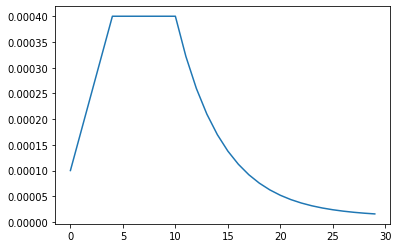

In [11]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

@tf.function
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Jensen-Shannon Divergence Consistency Loss

In [12]:
with strategy.scope():
    cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    kl_div = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)

    def batchmean(loss_obj, size):
        return tf.reduce_sum(loss_obj) * (1. / size)

    def jsd(model, p_org, p_aug1, p_aug2, labels):

        p_mixture = K.log(tf.clip_by_value((p_org + p_aug1 + p_aug2) / 3., 1e-7, 1))
        k1 = batchmean(kl_div(p_mixture, p_org), BATCH_SIZE)
        k2 = batchmean(kl_div(p_mixture, p_aug1), BATCH_SIZE)
        k3 = batchmean(kl_div(p_mixture, p_aug2), BATCH_SIZE)

        def loss_func(y_true, y_pred):
            loss = batchmean(cross_entropy(y_true, y_pred), BATCH_SIZE)
            loss += 12 * ( k1 + k2 + k3 ) / 3.
            return loss


        return loss_func(y_true=labels, y_pred=p_org)

## Step functions

In [13]:
STEPS_PER_TPU_CALL = 99
VALIDATION_STEPS_PER_TPU_CALL = 29

def train_step(data_iter):
    @tf.function
    def train_step_fn(images, augmix1, augmix2, labels):
        with tf.GradientTape() as tape:
            probabilities = model(images, training=True)
            p_aug1 = model(augmix1, training=True)
            p_aug2 = model(augmix2, training=True)
            loss = jsd(model, probabilities, p_aug1, p_aug2, labels)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        #update metrics
        train_accuracy.update_state(labels, probabilities)
        train_loss.update_state(loss)

    # this loop runs on the TPU
    for _ in tf.range(STEPS_PER_TPU_CALL):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))


def valid_step(data_iter):
    @tf.function
    def valid_step_fn(images, labels):
        probabilities = model(images, training=False)
        loss = loss_fn(labels, probabilities)

        # update metrics
        valid_accuracy.update_state(labels, probabilities)
        valid_loss.update_state(loss)

    # this loop runs on the TPU
    for _ in tf.range(VALIDATION_STEPS_PER_TPU_CALL):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

## Load model

In [14]:
with strategy.scope():
    net = tf.keras.applications.MobileNetV2(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    )
    net.trainable = True

    model = tf.keras.Sequential([
        net,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model.summary()
    
    # Instiate optimizer with learning rate schedule
    class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __call__(self, step):
            return lrfn(epoch=step//STEPS_PER_EPOCH)
        
    optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule())
    
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    train_loss = tf.keras.metrics.Sum()
    valid_loss = tf.keras.metrics.Sum()
    
    loss_fn = tf.keras.losses.sparse_categorical_crossentropy

9412608/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               133224    
Total params: 2,391,208
Trainable params: 2,357,096
Non-trainable params: 34,112
_________________________________________________________________


## Optimized training loop
(based on this notebook https://www.kaggle.com/mgornergoogle/custom-training-loop-with-100-flowers-on-tpu)

In [15]:
start_time = epoch_start_time = time.time()

train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset())
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(repeated=True))

print("Training steps per epoch:", STEPS_PER_EPOCH, "in increments of", STEPS_PER_TPU_CALL)
print("Validation images:", NUM_VALIDATION_IMAGES,
      "Batch size:", BATCH_SIZE,
      "Validation steps:", NUM_VALIDATION_IMAGES//BATCH_SIZE, 
      "in increments of", VALIDATION_STEPS_PER_TPU_CALL)
print("Repeated validation images:", int_div_round_up(NUM_VALIDATION_IMAGES, BATCH_SIZE*VALIDATION_STEPS_PER_TPU_CALL)*VALIDATION_STEPS_PER_TPU_CALL*BATCH_SIZE-NUM_VALIDATION_IMAGES)
History = namedtuple('History', 'history')
history = History(history={'loss': [], 'val_loss': [], 'sparse_categorical_accuracy': [], 'val_sparse_categorical_accuracy': []})

epoch = 0
train_data_iter = iter(train_dist_ds) 
valid_data_iter = iter(valid_dist_ds)

step = 0
epoch_steps = 0
while True:
    
    # run training step
    train_step(train_data_iter)
    epoch_steps += STEPS_PER_TPU_CALL
    step += STEPS_PER_TPU_CALL
    print('=', end='', flush=True)

    # validation run at the end of each epoch
    if (step // STEPS_PER_EPOCH) > epoch:
        print('|', end='', flush=True)
        
        # validation run
        valid_epoch_steps = 0
        for _ in range(int_div_round_up(NUM_VALIDATION_IMAGES, BATCH_SIZE*VALIDATION_STEPS_PER_TPU_CALL)):
            valid_step(valid_data_iter)
            valid_epoch_steps += VALIDATION_STEPS_PER_TPU_CALL
            print('=', end='', flush=True)

        # compute metrics
        history.history['sparse_categorical_accuracy'].append(train_accuracy.result().numpy())
        history.history['val_sparse_categorical_accuracy'].append(valid_accuracy.result().numpy())
        history.history['loss'].append(train_loss.result().numpy() / (BATCH_SIZE*epoch_steps))
        history.history['val_loss'].append(valid_loss.result().numpy() / (BATCH_SIZE*valid_epoch_steps))
        
        # report metrics
        epoch_time = time.time() - epoch_start_time
        print('\nEPOCH {:d}/{:d}'.format(epoch+1, EPOCHS))
        print('time: {:0.1f}s'.format(epoch_time),
              'loss: {:0.4f}'.format(history.history['loss'][-1]),
              'accuracy: {:0.4f}'.format(history.history['sparse_categorical_accuracy'][-1]),
              'val_loss: {:0.4f}'.format(history.history['val_loss'][-1]),
              'val_acc: {:0.4f}'.format(history.history['val_sparse_categorical_accuracy'][-1]),
              'lr: {:0.4g}'.format(lrfn(epoch)),
              'steps/val_steps: {:d}/{:d}'.format(epoch_steps, valid_epoch_steps), flush=True)
        
        # set up next epoch
        epoch = step // STEPS_PER_EPOCH
        epoch_steps = 0
        epoch_start_time = time.time()
        train_accuracy.reset_states()
        valid_accuracy.reset_states()
        valid_loss.reset_states()
        train_loss.reset_states()
        if epoch >= EPOCHS:
            break

optimized_ctl_training_time = time.time() - start_time
print("OPTIMIZED CTL TRAINING TIME: {:0.1f}s".format(optimized_ctl_training_time))

Training steps per epoch: 120 in increments of 99
Validation images: 3712 Batch size: 128 Validation steps: 29 in increments of 29
Repeated validation images: 0
==|=
EPOCH 1/30
time: 155.8s loss: 0.0153 accuracy: 0.5739 val_loss: 1.2078 val_acc: 0.6864 lr: 0.0001 steps/val_steps: 198/29
=|=
EPOCH 2/30
time: 61.5s loss: 0.0046 accuracy: 0.8581 val_loss: 0.9767 val_acc: 0.7454 lr: 0.000175 steps/val_steps: 99/29
=|=
EPOCH 3/30
time: 61.1s loss: 0.0029 accuracy: 0.9032 val_loss: 0.7657 val_acc: 0.7985 lr: 0.00025 steps/val_steps: 99/29
=|=
EPOCH 4/30
time: 59.9s loss: 0.0020 accuracy: 0.9373 val_loss: 0.8101 val_acc: 0.7923 lr: 0.000325 steps/val_steps: 99/29
==|=
EPOCH 5/30
time: 110.9s loss: 0.0011 accuracy: 0.9659 val_loss: 0.7727 val_acc: 0.8052 lr: 0.0004 steps/val_steps: 198/29
=|=
EPOCH 6/30
time: 59.2s loss: 0.0007 accuracy: 0.9798 val_loss: 0.6554 val_acc: 0.8324 lr: 0.0004 steps/val_steps: 99/29
=|=
EPOCH 7/30
time: 58.1s loss: 0.0005 accuracy: 0.9848 val_loss: 0.6673 val_acc: 0

## Save model

In [16]:
model.save('model_augmix.h5')

## Display training curves

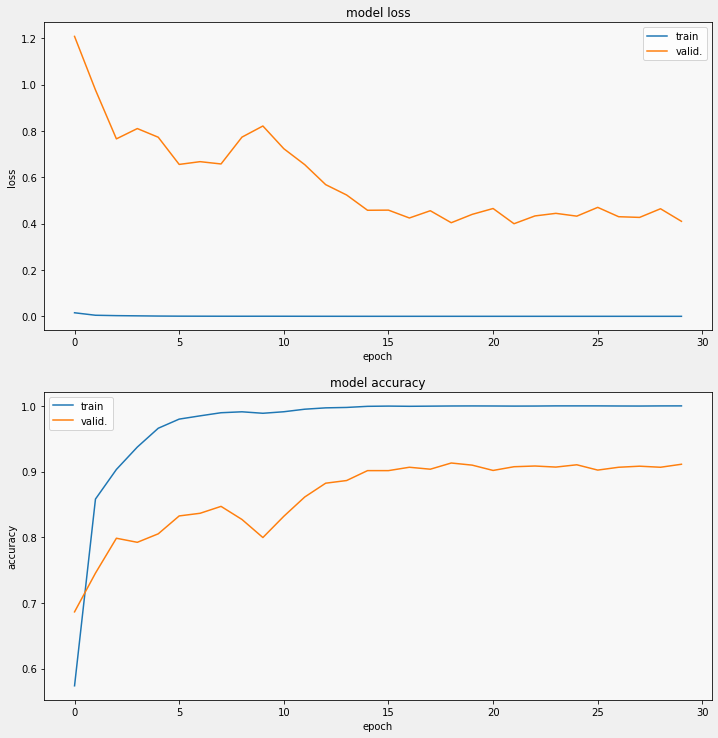

In [17]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

## Evaluate

In [18]:
def evaluate_model(model):
    validation_ds = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=True)
    y_true = [ label.numpy() for image, label in validation_ds]
    images = validation_ds.map(lambda image, label: image)
    probs = model.predict(images.batch(BATCH_SIZE))
    y_pred = np.argmax(probs, axis=-1)
    
    print(classification_report(y_true, y_pred, target_names=CLASSES))
    print("Macro f1-score: ", f1_score(y_true, y_pred, average='macro'))

In [19]:
evaluate_model(model)

                           precision    recall  f1-score   support

            pink primrose       0.97      0.94      0.95        79
hard-leaved pocket orchid       1.00      1.00      1.00         7
         canterbury bells       0.83      0.83      0.83         6
                sweet pea       0.50      0.67      0.57         6
            wild geranium       0.91      0.93      0.92       205
               tiger lily       0.87      0.80      0.83        25
              moon orchid       0.67      0.80      0.73         5
         bird of paradise       0.88      0.94      0.91        31
                monkshood       0.92      0.92      0.92        25
            globe thistle       0.79      0.96      0.87        24
               snapdragon       0.95      0.88      0.91        40
              colt's foot       0.92      0.92      0.92        13
              king protea       0.96      0.89      0.92        27
            spear thistle       0.97      0.96      0.97     

# Train with no augmentation

In [20]:
# free up memory since augmix takes a lot
del model, train_dist_ds, valid_dist_ds, train_data_iter, valid_data_iter, history, net

## Load model

In [21]:
with strategy.scope():
    net = tf.keras.applications.MobileNetV2(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    )
    net.trainable = True

    model = tf.keras.Sequential([
        net,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LRSchedule()),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               133224    
Total params: 2,391,208
Trainable params: 2,357,096
Non-trainable params: 34,112
_________________________________________________________________


## Train model

In [22]:
history = model.fit(
    get_training_dataset(augment=False), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=get_validation_dataset()
)

Train for 120 steps
Epoch 1/30
120/120 [==============================] - 62s 517ms/step - loss: 2.6075 - sparse_categorical_accuracy: 0.4370 - val_loss: 2.1332 - val_sparse_categorical_accuracy: 0.4461
Epoch 2/30
120/120 [==============================] - 9s 79ms/step - loss: 0.8991 - sparse_categorical_accuracy: 0.8010 - val_loss: 1.4265 - val_sparse_categorical_accuracy: 0.6078
Epoch 3/30
120/120 [==============================] - 10s 82ms/step - loss: 0.4698 - sparse_categorical_accuracy: 0.8927 - val_loss: 1.4710 - val_sparse_categorical_accuracy: 0.6121
Epoch 4/30
120/120 [==============================] - 10s 80ms/step - loss: 0.2802 - sparse_categorical_accuracy: 0.9354 - val_loss: 1.6718 - val_sparse_categorical_accuracy: 0.6164
Epoch 5/30
120/120 [==============================] - 10s 80ms/step - loss: 0.1844 - sparse_categorical_accuracy: 0.9510 - val_loss: 1.8254 - val_sparse_categorical_accuracy: 0.5603
Epoch 6/30
120/120 [==============================] - 10s 82ms/step - 

## Display training curves

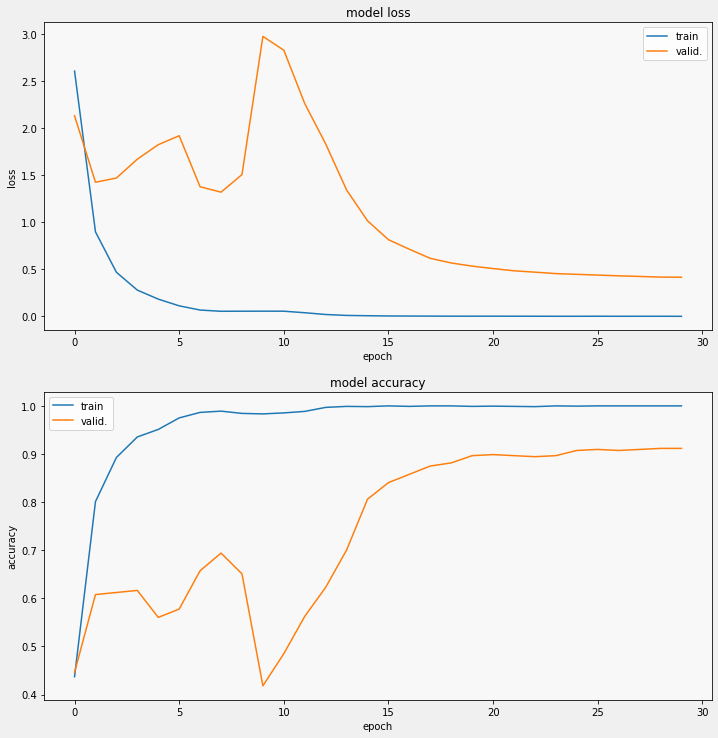

In [23]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

## Evaluate

In [24]:
evaluate_model(model)

                           precision    recall  f1-score   support

            pink primrose       0.93      0.89      0.91        79
hard-leaved pocket orchid       1.00      1.00      1.00         7
         canterbury bells       0.86      1.00      0.92         6
                sweet pea       0.83      0.83      0.83         6
            wild geranium       0.92      0.98      0.95       205
               tiger lily       0.85      0.92      0.88        25
              moon orchid       0.62      1.00      0.77         5
         bird of paradise       0.97      0.97      0.97        31
                monkshood       0.89      1.00      0.94        25
            globe thistle       0.88      0.92      0.90        24
               snapdragon       0.90      0.90      0.90        40
              colt's foot       1.00      1.00      1.00        13
              king protea       0.96      0.93      0.94        27
            spear thistle       0.92      0.95      0.94     